In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import matplotlib.cm as cm

#set stepsize patterns
H_GRDESC = [1]
H_2 = [2.9, 1.5] # taking nu = 0.1
H_3 = [1.5, 4.9, 1.5]
H_7 = [1.5, 2.2, 1.5, 12.0, 1.5, 2.2, 1.5]
H_15 = [1.4, 2.0, 1.4, 4.5, 1.4, 2.0, 1.4, 29.7, 1.4, 2.0, 1.4, 4.5, 1.4, 2.0, 1.4]
H_31 = [1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 8.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 72.3, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 8.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4]
H_63 = [1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 14.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 164.0, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 14.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4]
H_127 = [1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 23.5, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 370.0, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 23.5, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.5, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4]

H = [H_GRDESC,H_2,H_3,H_7,H_15,H_31,H_63,H_127]


#evaluate objective function without regularizer
def objective1(outputs, labels, model = None):
    # Convert labels to one-hot encoding
    labels_onehot = torch.zeros_like(outputs)
    for i, label in enumerate(labels):
        labels_onehot[i][label] = 1
    
    return nn.MSELoss()(outputs, labels_onehot)
# torch.norm(outputs - labels_onehot, p=2, dim=1).pow(2).mean()

#...with regularizer
def objective2(outputs, labels, model):
    return objective1(outputs, labels, model) + torch.norm(model.linear.weight, p=2 , dim=1).pow(2).mean()


# Define the linear model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(784, 10, bias=False)  # 28x28 = 784 input features, 10 output classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        return self.linear(x)

    # Define the custom non-constant step sizes
    def step_size_schedule(self, epoch, H):
        h = H[(epoch-1) % len(H)]
        # L = 2 * torch.norm(image.view(image.size(0), -1), p=2)**2
        return h / 4783.4

   
   # Define the data transforms including normalization
transform = transforms.Compose([
    ToTensor(), # automatically scales the images to [0,1] range
    Normalize((0.1307,), (0.3081,)) # calulated from the training dataset
])


# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print(f"Number of training examples: {len(train_dataset)}")


# Load MNIST test data
test_dataset = MNIST(root='./data', train=False, download=True)
# The transform is applied only when accessing the data via for ... in ... loop 

# Extract images (X_test) and labels (y_test) from the test dataset
X_test = test_dataset.data.unsqueeze(1).float()  # Add a channel dimension and convert to float
y_test = test_dataset.targets
print(f"Number of test examples: {len(X_test)}")

# # Calculate the mean and standard deviation
X_test = X_test.float() /255.0
mean = X_test.mean()
std = X_test.std()

X_test = (X_test - mean) / std  # Normalize the test data

Number of training examples: 60000
Number of test examples: 10000


In [2]:
L = 0
for images, _ in train_loader:
    norm = torch.norm(images.view(images.size(0), -1), p=2, dim=1).pow(2)
    L = max(L, 2* norm.max())

print(f"Estimated L: {L}")

Estimated L: 4783.421875


In [3]:
losses_H = []
test_error_rates_H = []
for H_i in H:
    criterion = objective1 
    # Create the linear model
    model = LinearModel()
    # nn.init.xavier_uniform_(model.linear.weight) # Initialize the weights using Xavier initialization
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # Lists to store the loss values and test errors
    losses = []
    test_error_rates = []

    # Train the model
    for epoch in tqdm(range(30)):
        for images, labels in train_loader:
            optimizer.zero_grad()
            # Update the learning rate for every batch
            optimizer.param_groups[0]['lr'] = model.step_size_schedule(epoch, H_i)

            output = model(images)
            loss = criterion(output, labels, model) # x is weight, A is image data, b is label data, Ax=b
            loss.backward()
            # Add gradient clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Record the loss
            losses.append(loss.item())

            # Test the model
            # Calculate test error using test data
            with torch.no_grad():
                outputs = model(X_test)
                predicted_labels = torch.argmax(outputs, dim=1)
                # test_error_rate = criterion(outputs, y_test, model)

                # Calculate the error rate
                test_error_rate = 1.0 - torch.sum(predicted_labels == y_test).item() / len(y_test)
            
            test_error_rates.append(test_error_rate)

        # print(f"Epoch {epoch+1}: Training Loss = {loss.item()}")
        
    losses_H.append(losses)
    test_error_rates_H.append(test_error_rates)

# Save the loss and test error data
np.save('losses_H.npy', losses_H)
np.save('test_error_rates_H.npy', test_error_rates_H)


100%|██████████| 30/30 [05:14<00:00, 10.47s/it]


C:\Users\Acer\AppData\Local\Temp\ipykernel_43520\142529724.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma')


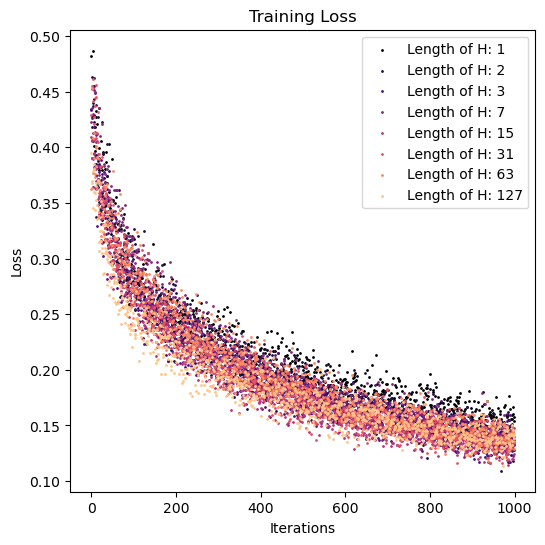

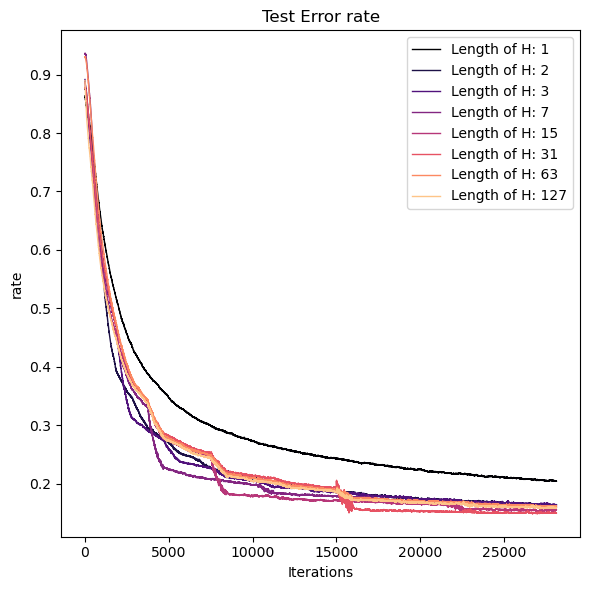

In [6]:

# Load the loss and test error data
losses_H = np.load('losses_H.npy')
test_error_rates_H = np.load('test_error_rates_H.npy')

# Create a color map for plotting
cmap = cm.get_cmap('magma')

# Plot losses_H
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
plt.figure(figsize=(6, 6))
for i, losses in enumerate(losses_H):
    plt.scatter(range(1000), losses[:1000], label=f"Length of H: {len(H[i])}", color=cmap(i / len(losses_H)), s=1)
    # plt.plot(range(200), losses[:200], label=f"Length of H: {len(H[i])}", color=cmap(i / len(losses_H)), linewidth=0.3)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot test_error_rates_H
# plt.subplot(1, 2, 2)
plt.figure(figsize=(6, 6))
for i, test_error_rates in enumerate(test_error_rates_H):
    plt.plot(test_error_rates, label=f"Length of H: {len(H[i])}", color=cmap(i / len(test_error_rates_H)), linewidth=1)
plt.xlabel("Iterations")
plt.ylabel("rate")
plt.title("Test Error rate")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
